Code of the:

Final Project: Variational Autoencoders.

Bayesian Statistics and Probabilistic Programming

2023-2024

Jaime Leonardo Sánchez Salazar,
Sergio Hernández Antón,
David Íñiguez Gómez,
Sergi Cantón Simó


# VAE Model

The following model is from the [GitHub repository](https://github.com/jz95/ml-paper-lab/tree/master) or from the [forked GitHub repository](https://github.com/SergiCSim/Bayesian-VAE/tree/master), but we found interesting to include it here to have it next to the code of the training and experiments. Also, here we have added more comments than the ones that were in the original repository to the model to make it more understandable. However, the written detailed explanation of the VAE model is in the PDF.

As it is explained in the PDF, the model has two parts: a Gaussian encoder (```GaussianMLP```) and a Bernoulli decoder (```BernoulliDecoder```). Nevertheless, in the python implementation there is also another class: ```VAEModel```. This class just integrates both the encoder and the decoder, and inherits from the ```BaseModel```.

In [1]:
import torch

class BaseModel(torch.nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def compute_loss(self, data, reduction='mean') -> torch.Tensor:
        assert reduction in ('mean', 'sum', None), f'invalid reduction approach {reduction}'
        raise NotImplementedError

    def pred(self, data):
        raise NotImplementedError

class VAEModel(BaseModel):
    """
    the variational auto-encoder for MNIST data, see the original paper for reference:
    https://arxiv.org/abs/1312.6114
    """
    def __init__(self, dim_latent, dim_input, dim_hidden):
        super(VAEModel, self).__init__()
        self.encoder = GaussianMLP(dim_latent, dim_input, dim_hidden)
        self.decoder = BernoulliDecoder(dim_latent, dim_input, dim_hidden)

    def compute_loss(self, data, reduction='mean'):
        if reduction == 'mean':
            return - torch.mean(self.forward(data))
        elif reduction == 'sum':
            return - torch.sum(self.forward(data))


    def forward(self, x) -> torch.Tensor:
        """
        corresponds to equation (10) in the paper
        :return: the estimated ELBO value
        """
        mean, var = self.encoder.get_mean_and_var(x)  # [b, n], [b, n]
        z = mean + torch.sqrt(var) * torch.randn(var.shape).to(x.device)
        # the KL divergence term plus the MC estimate of decoder
        return 1 / 2 * torch.sum(1 + torch.log(var) - mean ** 2 - var, dim=1) + self.decoder(x, z)


class GaussianMLP(torch.nn.Module):
    """
    modelling the prob p(a|b), where a, b are n-d, m-d vectors
    can be used either as encoder or decoder
    described in the Appendix C
    """
    def __init__(self, dim_a, dim_b, dim_hidden):
        super(GaussianMLP, self).__init__()
        # Hidden linear layer with tanh activation function
        self.hidden_layer = torch.nn.Sequential(torch.nn.Linear(dim_b, dim_hidden), torch.nn.Tanh())
        # Linear layer to calculate the mean
        self.mean_transform_layer = torch.nn.Linear(dim_hidden, dim_a)
        # Linear layer to calculate the variance
        self.var_transform_layer = torch.nn.Linear(dim_hidden, dim_a)

    def get_mean_and_var(self, b):
        """
        :param b: the condition part, [batch, m]
        :return: (mean, variance) [batch, n], [batch, n]
        """
        # Pass data through the linear hidden layer
        h = self.hidden_layer(b)  # [batch, h]
        # Calculate the mean and the variance. Note that the variance is calculated by exponenciating the result
        return self.mean_transform_layer(h), torch.exp(self.var_transform_layer(h))

    def forward(self, a, b):
        """
        give the log prob of p(a|b)
        :param a: [batch, n]
        :param b: [batch, m]
        :return: [batch, ]
        """
        dim_a = a.shape[1]
        mean, var = self.get_mean_and_var(b)  # [batch, n], [batch, n]
        inv_covar = torch.einsum('bi, ij -> bij', 1 / var, torch.eye(dim_a))  # inversed covariance mat, [b, n, n]
        exponent = - 1 / 2 * torch.einsum('bi, bi -> b', torch.einsum('bi, bij->bj', a - mean, inv_covar), a - mean)  # [b,]

        return - dim_a / 2 * torch.log(torch.tensor(2 * torch.pi)) \
               - 1 / 2 * torch.sum(torch.log(var), dim=1) + exponent


    def generate(self, b):
        """
        :param b: [batch, dim_b]
        :return: [batch, dim_a]
        """
        with torch.no_grad():
            # Calculate the mean and the variance
            mean, var = self.get_mean_and_var(b)
            # Sample from the gaussian distiburion with the mean and the variance calculated
            return mean + torch.sqrt(var) * torch.randn(var.shape)


class BernoulliDecoder(torch.nn.Module):
    """
    The decoder modelling likelihood p(x|z),
    suitable for binary-valued data, or the real-value between 0 and 1
    described in the Appendix C
    """
    def __init__(self, dim_latent, dim_input, dim_hidden):
        super(BernoulliDecoder, self).__init__()
        self.layer = torch.nn.Sequential(
            # Hidden linear layer with tanh activation function
            torch.nn.Linear(dim_latent, dim_hidden),
            torch.nn.Tanh(),
            # Output linear layer with sigmoid activation function
            torch.nn.Linear(dim_hidden, dim_input),
            torch.nn.Sigmoid()
        )

    def forward(self, x, z):
        """
        evaluate the log - prob of p(x|z)
        :param x: [batch, n]
        :param z: the given latent variables, [b, m]
        :return: [batch, ]
        """
        y = self.layer(z)  # [b, n]
        return torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y), dim=1)

    def generate(self, z):
        """
        generate data points given the latent variables, i.e. draw x ~ p(x|z)
        :param z: the given latent variables, [batch, m]
        :return: generated data points, [batch, n]
        """
        with torch.no_grad():
            # [batch, n]
            # Generate and return the flattened image
            y = self.layer(z)
            return torch.where(torch.rand(y.shape) > y, 0., 1.)

    def prob(self, z):
        """
        evaluate the conditional probability
        :param z: the given latent variables, [batch, m]
        :return: [batch, n], 0 <= elem <= 1
        """
        with torch.no_grad():
            # Calculate the probabilities
            return self.layer(z)


# Before the experiments

Here, some previous steps must be done before start performing the experiments.

First of all, clone the repository and install necessary libraries. Then, import some libraries and define some hyperparameters. Finally, download the MNIST data.

In [2]:
import os

# Create the directory if it doesn't exist
os.makedirs("/content/Bayesian-VAE", exist_ok=True)

# Clone the git repository
!git clone https://github.com/SergiCSim/Bayesian-VAE.git
# Move to the repository folder
%cd Bayesian-VAE/
# Install the required libraries
!pip install -r requirements.txt

!python setup.py develop

Cloning into 'Bayesian-VAE'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 204 (delta 81), reused 174 (delta 58), pack-reused 0
Receiving objects: 100% (204/204), 1.35 MiB | 8.18 MiB/s, done.
Resolving deltas: 100% (81/81), done.
/content/Bayesian-VAE
ERROR: Could not find a version that satisfies the requirement torch==1.8.2 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1)
ERROR: No matching distribution found for torch==1.8.2
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
     

In [3]:
# Import necessary libraries

from paperlab.zoo import vae
from paperlab.core import Config, ExpRunner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
# Definition of the hyperparameters of the VAE model

# Number of training epochs of the model
NUM_EPOCH = 10

basic_params = {
    'model.dim_latent': None, # Latent space dimension. Not fixed because will be changed
    'model.dim_input': 28 * 28, # Input dimension: Number of pixels of the MNIST images
    'model.dim_hidden': 500, # Dimension of the hidden layer
    'learning.batch_size': 100, # Batch size
    'learning.lr': 0.02, # Learning rate
    'learning.num_epoch': NUM_EPOCH, # Number of epochs
}

In [5]:
import torchvision
from torchvision.transforms import ToTensor
from paperlab.utils import get_project_root

root = get_project_root()

# Download MNIST training dataset
train_dataset = torchvision.datasets.MNIST(root=os.path.join(root, '.cache', 'data'),
                                           train=True,
                                           transform=ToTensor(),
                                           download=True)

# Download MNIST testing dataset
test_dataset = torchvision.datasets.MNIST(root=os.path.join(root, '.cache', 'data'),
                                          train=False,
                                          transform=ToTensor(),
                                          download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 42229637.18it/s]


Extracting /content/Bayesian-VAE/.cache/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/Bayesian-VAE/.cache/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1048966.44it/s]


Extracting /content/Bayesian-VAE/.cache/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/Bayesian-VAE/.cache/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9713658.04it/s]


Extracting /content/Bayesian-VAE/.cache/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/Bayesian-VAE/.cache/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2424656.84it/s]

Extracting /content/Bayesian-VAE/.cache/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/Bayesian-VAE/.cache/data/MNIST/raw



# Experiments

In this section there is the code of the three experiments performed and explained in detail in the PDF.

## Comparisons Between Original and Generated Images

In [6]:
def plot_comparison(model, dataset, indices):
    """Function to plot the comparison of the original images with the images
       generated with the model 'model'. The original images selected ane the
       ones corresponding to the indices 'indices' in the dataset 'dataset'"""

    # Crate matrix of plots with 10 rows (one for each digit) and 2 columns
    f, ax = plt.subplots(10, 2,
                        figsize=(10, 50),
                        gridspec_kw={'wspace':0, 'hspace':0},
                        squeeze=True)

    # Iterate for each index
    for i, idx in enumerate(indices):

        # Select the i-th digit image
        original_image = dataset[idx][0].reshape(1, 28*28)
        # Calculate the latent respresentacion of the image with the encoder
        z = model.encoder.generate(original_image)
        # Reconstruct the image with z from the decoder
        generated_image = model.decoder.prob(z)

        # Reshape both images to 28x28
        original_image = original_image.cpu().data.numpy().reshape(28, 28)
        generated_image = generated_image.cpu().data.numpy().reshape(28, 28)

        # Show both images
        ax[i, 0].imshow(original_image, cmap='Greys', aspect='auto')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(generated_image, cmap='Greys', aspect='auto')
        ax[i, 1].axis('off')

In [7]:
# Fix a seed to reproduce
np.random.seed(42)

# Select the labels and the indices of the images
labels = test_dataset.targets
indices = [np.random.choice(np.where(labels == label)[0]) for label in range(10)]

#### Latent Space Dimension of 2

In [8]:
# Set the latent space dimension to 2
basic_params['model.dim_latent'] = 2
config = Config(**basic_params)

# Train the VAE model
model_2, *_ = vae.exp(config, return_model=True)

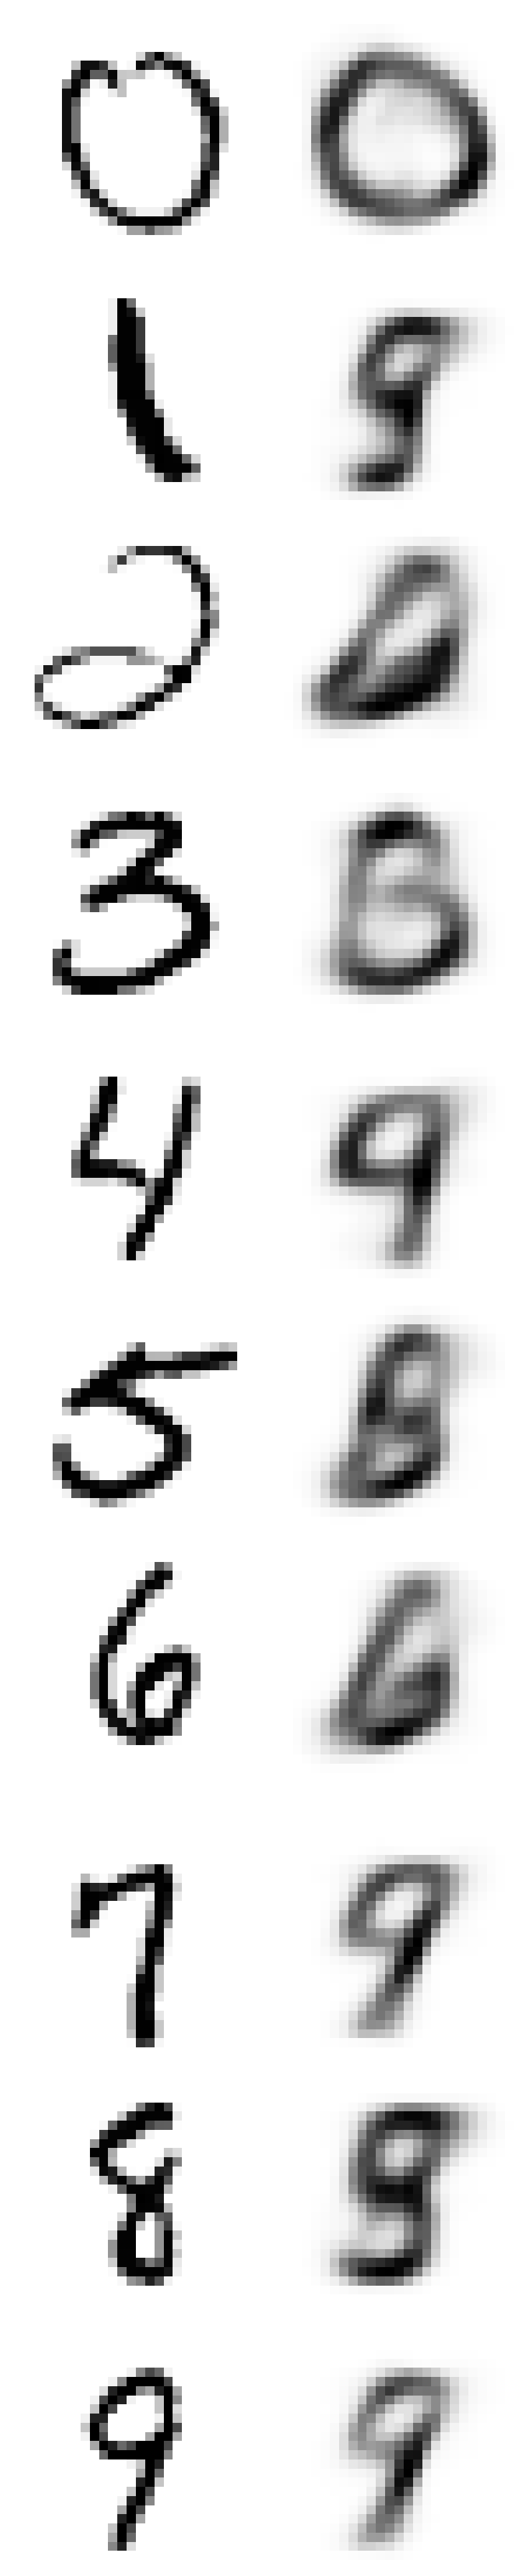

In [9]:
# Plot the comparison between original and generated images
plot_comparison(model_2, test_dataset, indices)

#### Latent Space Dimension of 5

In [10]:
# Set the latent space dimension to 5
basic_params['model.dim_latent'] = 5
config = Config(**basic_params)

# Train the VAE model
model_5, *_ = vae.exp(config, return_model=True)

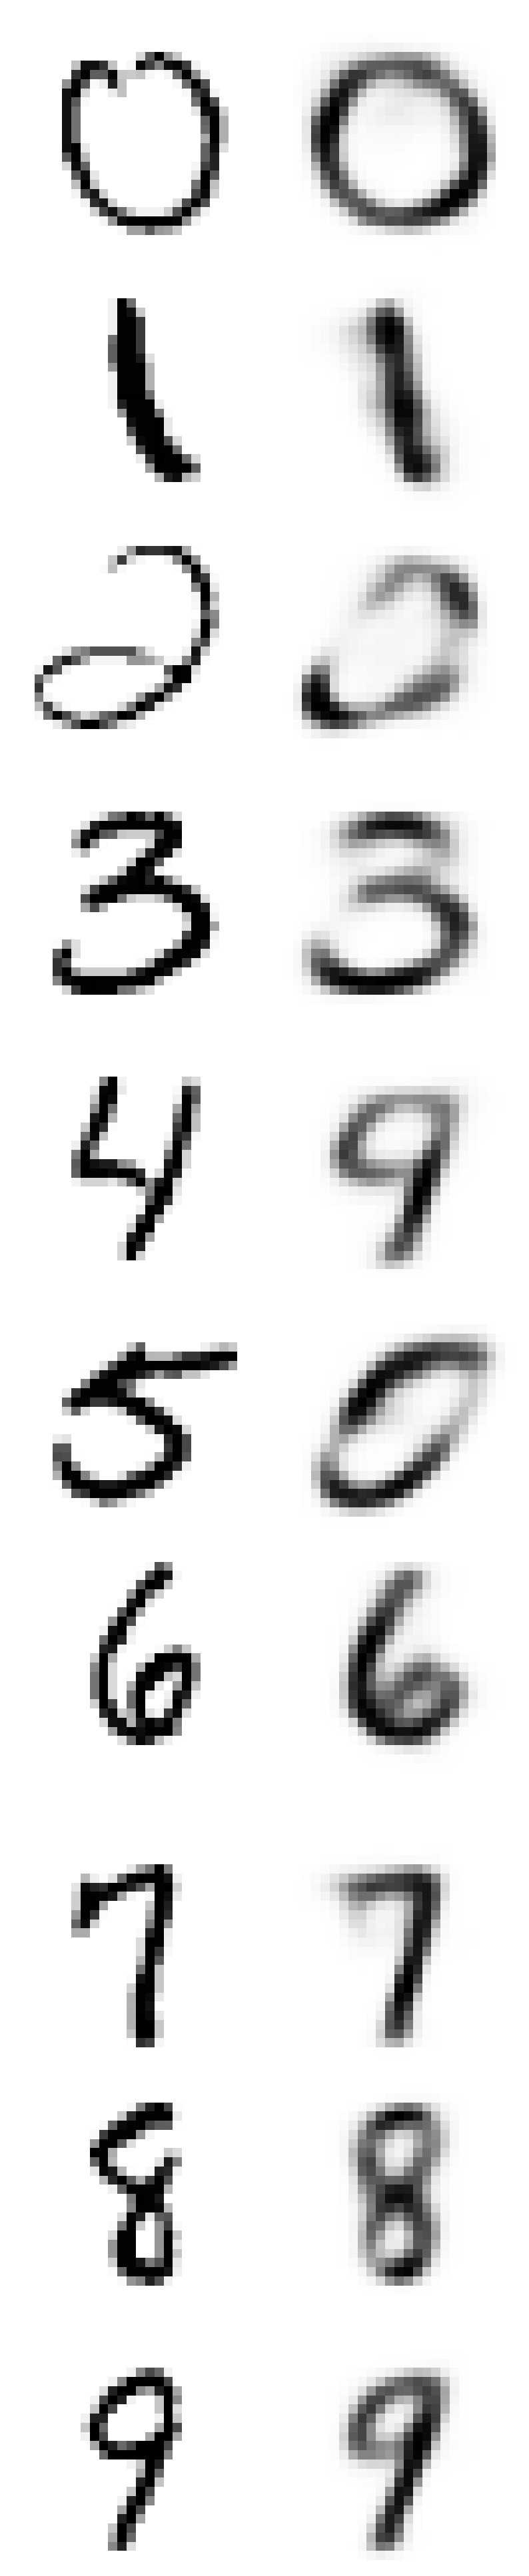

In [11]:
# Plot the comparison between original and generated images
plot_comparison(model_5, test_dataset, indices)

#### Latent Space Dimension of 10

In [12]:
# Set the latent space dimension to 10
basic_params['model.dim_latent'] = 10
config = Config(**basic_params)

# Train the VAE model
model_10, *_ = vae.exp(config, return_model=True)

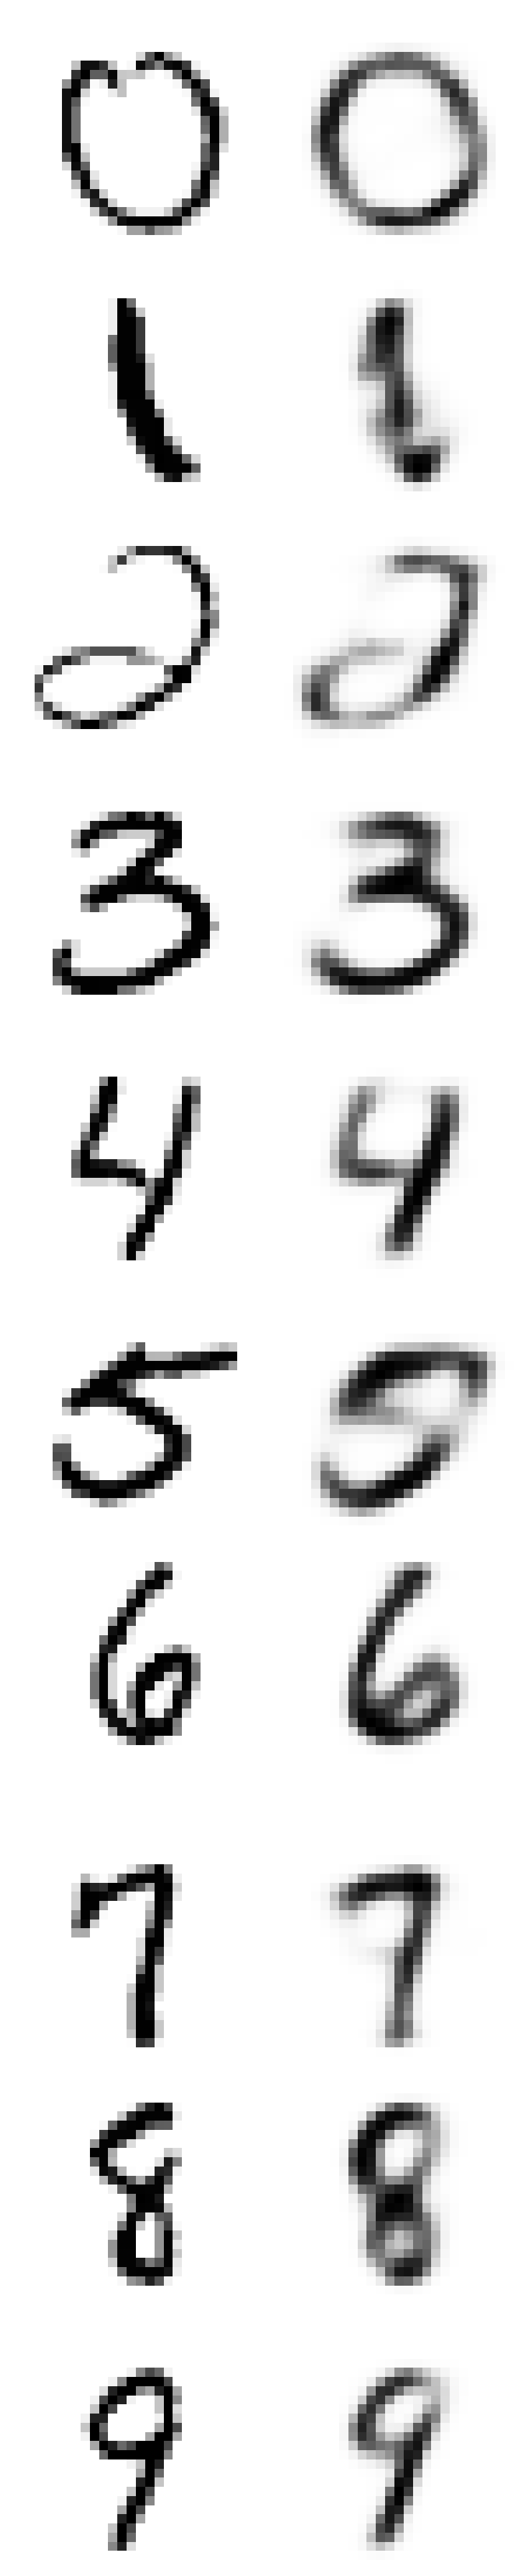

In [13]:
# Plot the comparison between original and generated images
plot_comparison(model_10, test_dataset, indices)

In [14]:
# Set the latent space dimension to 50
basic_params['model.dim_latent'] = 50
config = Config(**basic_params)

# Train the VAE model
model_50, *_ = vae.exp(config, return_model=True)

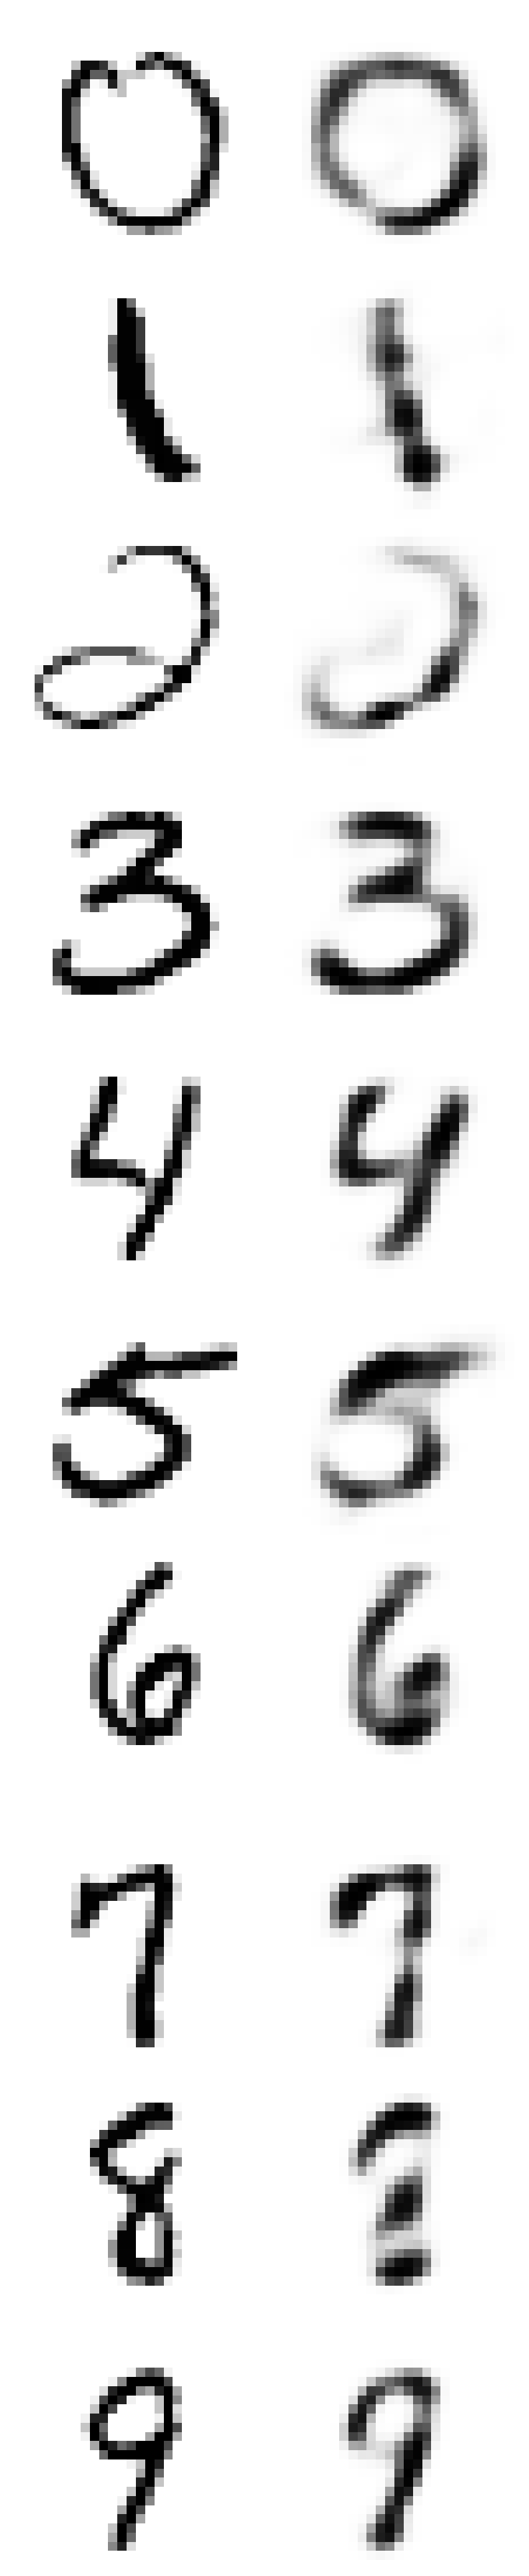

In [15]:
# Plot the comparison between original and generated images
plot_comparison(model_50, test_dataset, indices)

## Learned MNIST Manifold in Dimension 2

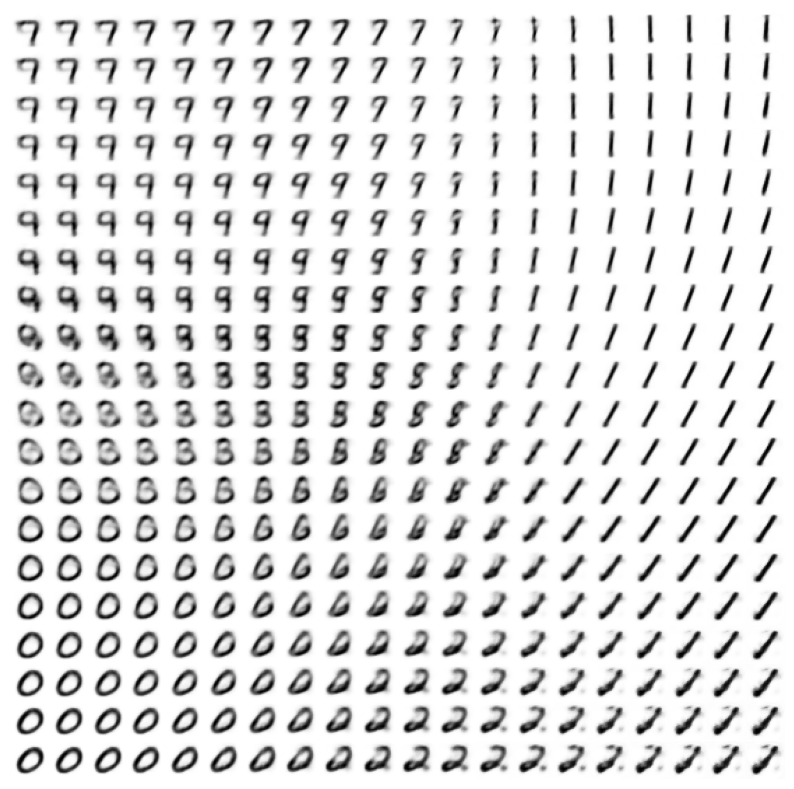

In [16]:
# Set number of rows and columns of the meshgrid
num_row, num_col = 20, 20

# Create the values of z that will be used to generate the images of the meshgrid
xs, ys = np.meshgrid(np.linspace(-3, 3, num_row), np.linspace(3, -3, num_col))
z = np.stack([xs.flatten(), ys.flatten()], axis=1)
z = torch.tensor(z, dtype=torch.float)

# Generate the images with the z vectors
draw_samples = model_2.decoder.prob(z)
imgs = draw_samples.cpu().data.numpy().reshape(-1, 28, 28)

# Crate the 20x20 meshgrid
f, ax = plt.subplots(num_row, num_col,
                     figsize=(10, 10),
                     gridspec_kw={'wspace':0, 'hspace':0},
                     squeeze=True)

# Fill the meshgrid and show the images
for i in range(num_row):
    for j in range(num_col):
        im = imgs[num_row * i + j]
        ax[i, j].imshow(im, cmap='Greys', aspect='auto')
        ax[i, j].axis('off')

### Clusters in the Latent Space in Dimension 2

In [17]:
# Create the lists to store z1 (x) and z2 (y) values for each digit of the dataset
latent_variables_x = [[] for _ in range(10)]
latent_variables_y = [[] for _ in range(10)]

# Iterate for each sample of the MNIST train dataset
for i, (image, label) in enumerate(train_dataset):
    # Calculate the latent vector of the image
    z = model_2.encoder.generate(image.reshape(1, 28*28))
    # Store the x and y coordinates of the vector
    x, y = z.tolist()[0]
    latent_variables_x[label].append(x)
    latent_variables_y[label].append(y)

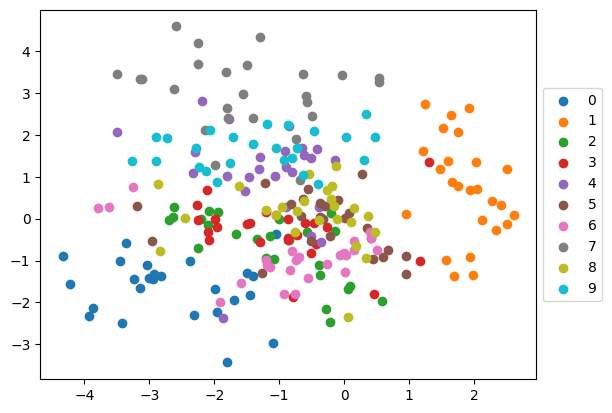

In [18]:
# Create the scatter plot of the latent vectors (points) of the 24 selected images
fig, ax = plt.subplots()

for label in range(10):
    ax.scatter(latent_variables_x[label][:5000:200], latent_variables_y[label][:5000:200], label=label)
    #ax.scatter(latent_variables_x[label][:10], latent_variables_y[label][:10], label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))